# Comparing negative binomial and normal linear regression models

The goal of this notebook is to compare negative binomial and normal models of real CRISPR-screen data.
Comparisons will be made on computational efficiency, MCMC diagnositics, model accuracy and fitness, and posterior predictive checks.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.data_processing import vectors as vhelp
from src.globals import PYMC3
from src.io import cache_io, data_io
from src.loggers import set_console_handler_level
from src.modeling import pymc3_helpers as pmhelp
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.WARN)

gg.theme_set(
    gg.theme_classic()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
        panel_grid_major_y=gg.element_line(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 212
np.random.seed(RANDOM_SEED)

## Data

In [5]:
crc_subsample_modeling_data_path = data_io.data_path(data_io.DataFile.crc_subsample)
crc_subsample_modeling_data = achelp.read_achilles_data(
    crc_subsample_modeling_data_path, low_memory=False, set_categorical_cols=True
)
crc_subsample_modeling_data.head()

sgrna     replicate_id       lfc             p_dna_batch  \
0  CTTGTTAGATAATGGAACT     LS513_c903R1 -1.100620       ERS717283.plasmid   
1  CTTGTTAGATAATGGAACT      CL11_c903R1 -0.572939       ERS717283.plasmid   
2  CTTGTTAGATAATGGAACT      HT29_c904R1  0.054573       ERS717283.plasmid   
3  CTTGTTAGATAATGGAACT     SNUC1_c903R4  0.700923       ERS717283.plasmid   
4  CTTGTTAGATAATGGAACT  KM12_c908R1_100 -1.123352  CRISPR_C6596666.sample   

   genome_alignment hugo_symbol  screen  multiple_hits_on_gene  \
0  chr2_157544604_-      ACVR1C  sanger                   True   
1  chr2_157544604_-      ACVR1C  sanger                   True   
2  chr2_157544604_-      ACVR1C  sanger                   True   
3  chr2_157544604_-      ACVR1C  sanger                   True   
4  chr2_157544604_-      ACVR1C  sanger                   True   

  sgrna_target_chr  sgrna_target_pos  ... num_mutations  any_deleterious  \
0                2         157544604  ...             0              NaN   
1                2         157544604  ...             0              NaN   
2                2         157544604  ...             0              NaN   
3                2         157544604  ...             0              NaN   
4                2         157544604  ...             0              NaN   

   any_tcga_hotspot  any_cosmic_hotspot is_mutated copy_number     lineage  \
0               NaN                 NaN      False    0.964254  colorectal   
1               NaN                 NaN      False    1.004888  colorectal   
2               NaN                 NaN      False    1.014253  colorectal   
3               NaN                 NaN      False    0.946028  colorectal   
4               NaN                 NaN      False    1.048861  colorectal   

   primary_or_metastasis  is_male   age  
0                primary     True  63.0  
1                primary     True   NaN  
2                primary    False  44.0  
3             metastasis     True  71.0  
4                primary      NaN   NaN  

[5 rows x 23 columns]

In [6]:
crc_subsample_modeling_data.columns.to_list()

['sgrna',
 'replicate_id',
 'lfc',
 'p_dna_batch',
 'genome_alignment',
 'hugo_symbol',
 'screen',
 'multiple_hits_on_gene',
 'sgrna_target_chr',
 'sgrna_target_pos',
 'depmap_id',
 'read_counts',
 'rna_expr',
 'num_mutations',
 'any_deleterious',
 'any_tcga_hotspot',
 'any_cosmic_hotspot',
 'is_mutated',
 'copy_number',
 'lineage',
 'primary_or_metastasis',
 'is_male',
 'age']

In [7]:
data = crc_subsample_modeling_data[
    ~crc_subsample_modeling_data.read_counts.isna()
].reset_index(drop=True)
data = achelp.set_achilles_categorical_columns(data)
data.shape

(570, 23)

In [8]:
# REMOVE THIS ONCE MUNGE IS RE-RUN TO CHANGE COLUMNS.
data = data.rename(columns={"read_counts": "counts_final"})
data["counts_initial"] = data.counts_final / (2 ** data.lfc)

In [9]:
data["copy_number_scaled"] = vhelp.careful_zscore(data.copy_number.values)

## Model fitting

Fit models with hierarchical structure for gene and copy number effect per cell line.

For each model:

$$ 
\begin{aligned} 
\mu_{\beta_0} &\sim \text{N}(0, 2.5) \quad \sigma_{\beta_0} \sim \text{HN}(2.5) \\
\mu_{\beta_\text{CNA}} &\sim \text{N}(0, 2.5) \quad \sigma_{\beta_\text{CNA}} \sim \text{HN}(2.5) \\ 
\beta_0 &\sim_g \text{N}(\mu_{\beta_0}, \sigma_{\beta_0}) \\
\beta_\text{CNA} &\sim_g \text{N}(\mu_{\beta_\text{CNA}}, \sigma_{\beta_\text{CNA}}) \\
\end{aligned}
$$

For the negative binomial:

$$
\begin{aligned}
\eta &= \beta_0[g] + x_\text{cna} \beta_\text{CNA}[g] \\
\mu &= \exp(\eta) \\
\alpha &\sim \text{HN}(0, 5) \\
y &\sim \text{NB}(\mu x_\text{initial}, \alpha)
\end{aligned}
$$

For the normal model:

$$
\begin{aligned}
\mu &= \beta_0[g] + x_\text{cna} \beta_\text{CNA}[g] \\
\sigma &\sim \text{HN}(0, 5) \\
y &\sim \text{N}(\mu, \sigma)
\end{aligned}
$$

In [10]:
gene_idx = dphelp.get_indices(data, "hugo_symbol")
n_genes = len(data.hugo_symbol.unique())
print(f"number of genes: {n_genes}")

number of genes: 60


### Negative Binomial model

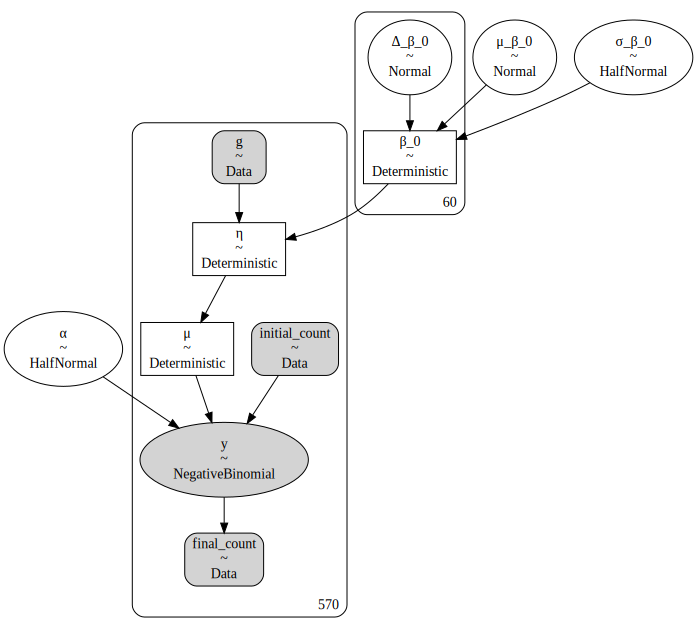

In [11]:
with pm.Model() as nb_model:
    g = pm.Data("g", gene_idx)
    #     x_cna = pm.Data("x_cna", data.copy_number_scaled.values)
    ct_i = pm.Data("initial_count", data.counts_initial.values)
    ct_f = pm.Data("final_count", data.counts_final.values)

    β_0 = pmhelp.hierarchical_normal("β_0", shape=n_genes, centered=False)
    #     β_cna = pmhelp.hierarchical_normal(
    #         "β_cna", shape=n_genes, centered=False, mu_sd=1.0, sigma_sd=1.0
    #     )
    η = pm.Deterministic("η", β_0[g])  # + β_cna[g] * x_cna)

    μ = pm.Deterministic("μ", pm.math.exp(η))
    α = pm.HalfNormal("α", 5)

    y = pm.NegativeBinomial("y", μ * ct_i, α, observed=ct_f)

pm.model_to_graphviz(nb_model)

### Normal linear regression model

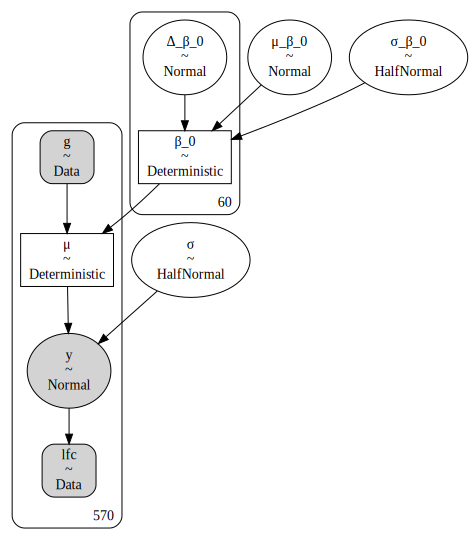

In [12]:
with pm.Model() as lin_model:
    g = pm.Data("g", gene_idx)
    #     x_cna = pm.Data("x_cna", data.copy_number_scaled.values)
    lfc = pm.Data("lfc", data.lfc.values)

    β_0 = pmhelp.hierarchical_normal("β_0", shape=n_genes, centered=False)
    #     β_cna = pmhelp.hierarchical_normal(
    #         "β_cna", shape=n_genes, centered=False, mu_sd=1.0, sigma_sd=1.0
    #     )
    μ = pm.Deterministic("μ", β_0[g])  # + β_cna[g] * x_cna)

    σ = pm.HalfNormal("σ", 5)

    y = pm.Normal("y", μ, σ, observed=lfc)

pm.model_to_graphviz(lin_model)

### Sampling from the models

In [13]:
pm_sample_kwargs = {
    "draws": 2000,
    "chains": 4,
    "tune": 3000,
    "random_seed": 400,
    "target_accept": 0.95,
    "return_inferencedata": True,
}
pm_sample_ppc_kwargs = {"random_seed": 400}

The fitting procedures are timed, but due to a quirk of `theano`, the first always takes a bit longer.
From experience, I put together the following table:

| model  | sampling (sec.) | post. pred. (sec.) | total (min.) |
|--------|-----------------|--------------------|--------------|
| NB     | 117             | 115                | 4.21         |
| normal | 83              | 139                | 3.95         |

In [14]:
tic = time()
with nb_model:
    nb_trace = pm.sample(**pm_sample_kwargs)
    ppc = pm.sample_posterior_predictive(nb_trace, **pm_sample_ppc_kwargs)
    nb_trace.extend(az.from_pymc3(posterior_predictive=ppc))

toc = time()
print(f"model fitting time: {(toc - tic) / 60:.2f} minutes")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, Δ_β_0, σ_β_0, μ_β_0]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 126 seconds.


model fitting time: 4.77 minutes


In [15]:
tic = time()
with lin_model:
    lin_trace = pm.sample(**pm_sample_kwargs)
    ppc = pm.sample_posterior_predictive(lin_trace, **pm_sample_ppc_kwargs)
    lin_trace.extend(az.from_pymc3(posterior_predictive=ppc))

toc = time()
print(f"model fitting time: {(toc - tic) / 60:.2f} minutes")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, Δ_β_0, σ_β_0, μ_β_0]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 91 seconds.


model fitting time: 4.37 minutes


## Model comparison

### LOO-CV

In [16]:
model_collection: dict[str, az.InferenceData] = {
    "negative binomial": nb_trace,
    "normal": lin_trace,
}
model_comparison = az.compare(model_collection)
model_comparison

rank          loo      p_loo        d_loo        weight  \
normal                0  -498.793771  42.954550     0.000000  1.000000e+00   
negative binomial     1 -3675.909542  40.017011  3177.115771  2.764455e-14   

                          se        dse  warning loo_scale  
normal             22.823044   0.000000    False       log  
negative binomial  25.461840  20.854011    False       log

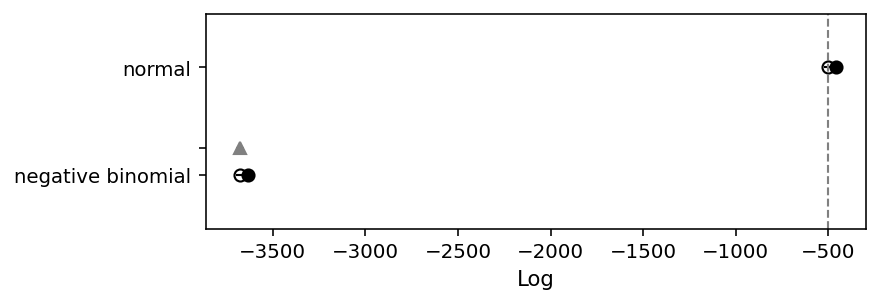

In [17]:
az.plot_compare(model_comparison);

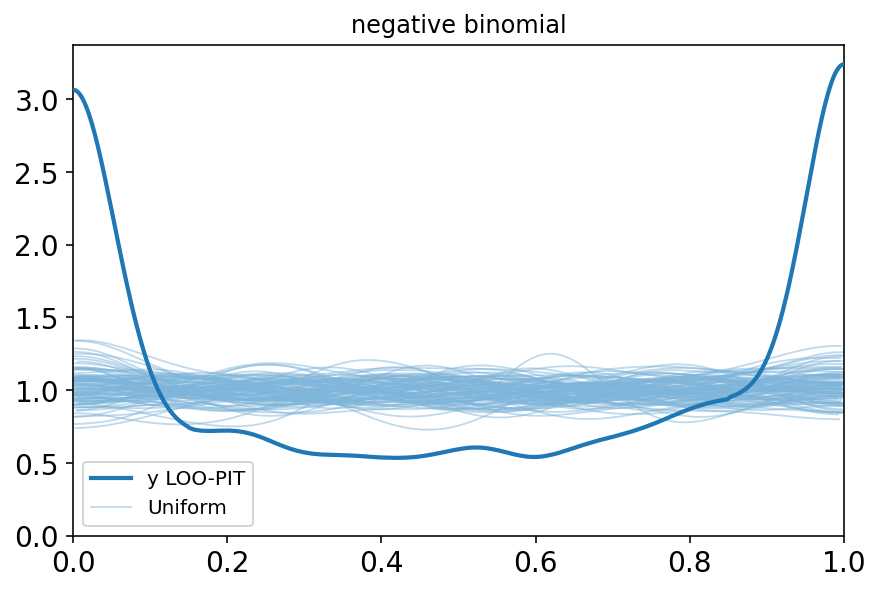

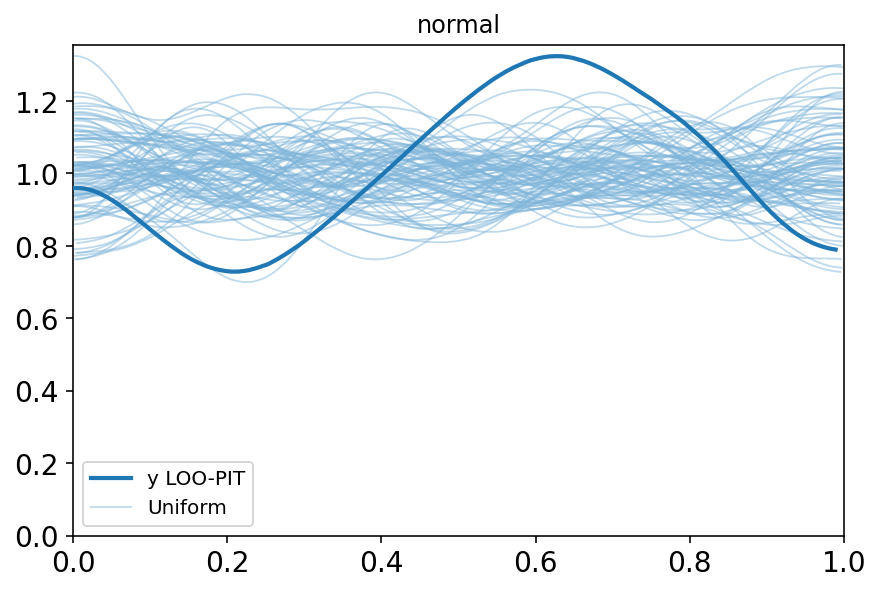

In [18]:
for name, idata in model_collection.items():
    az.plot_loo_pit(idata, y="y")
    plt.title(name)
    plt.show()

### Posterior distributions

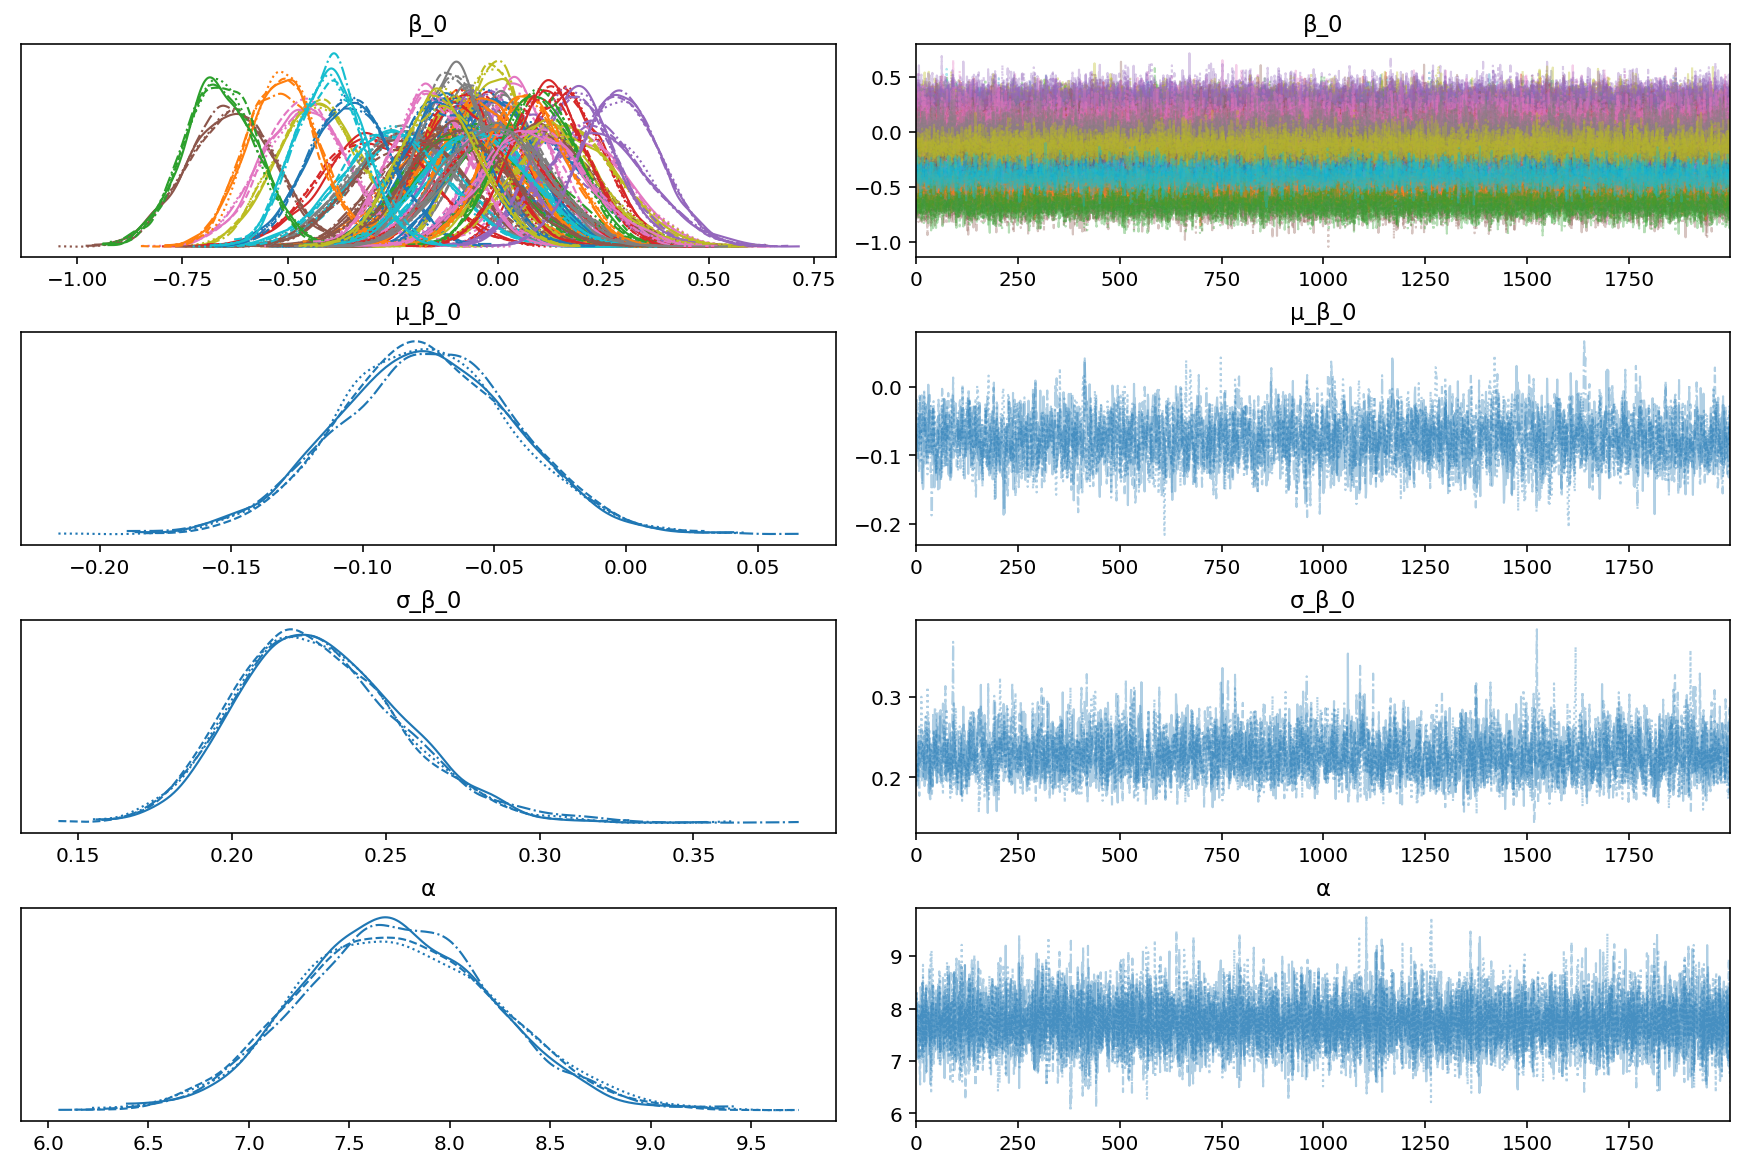

In [19]:
shared_varnames = ["β_0", "μ_β_0", "σ_β_0"]
nb_varnames = shared_varnames.copy() + ["α"]
az.plot_trace(nb_trace, var_names=nb_varnames);

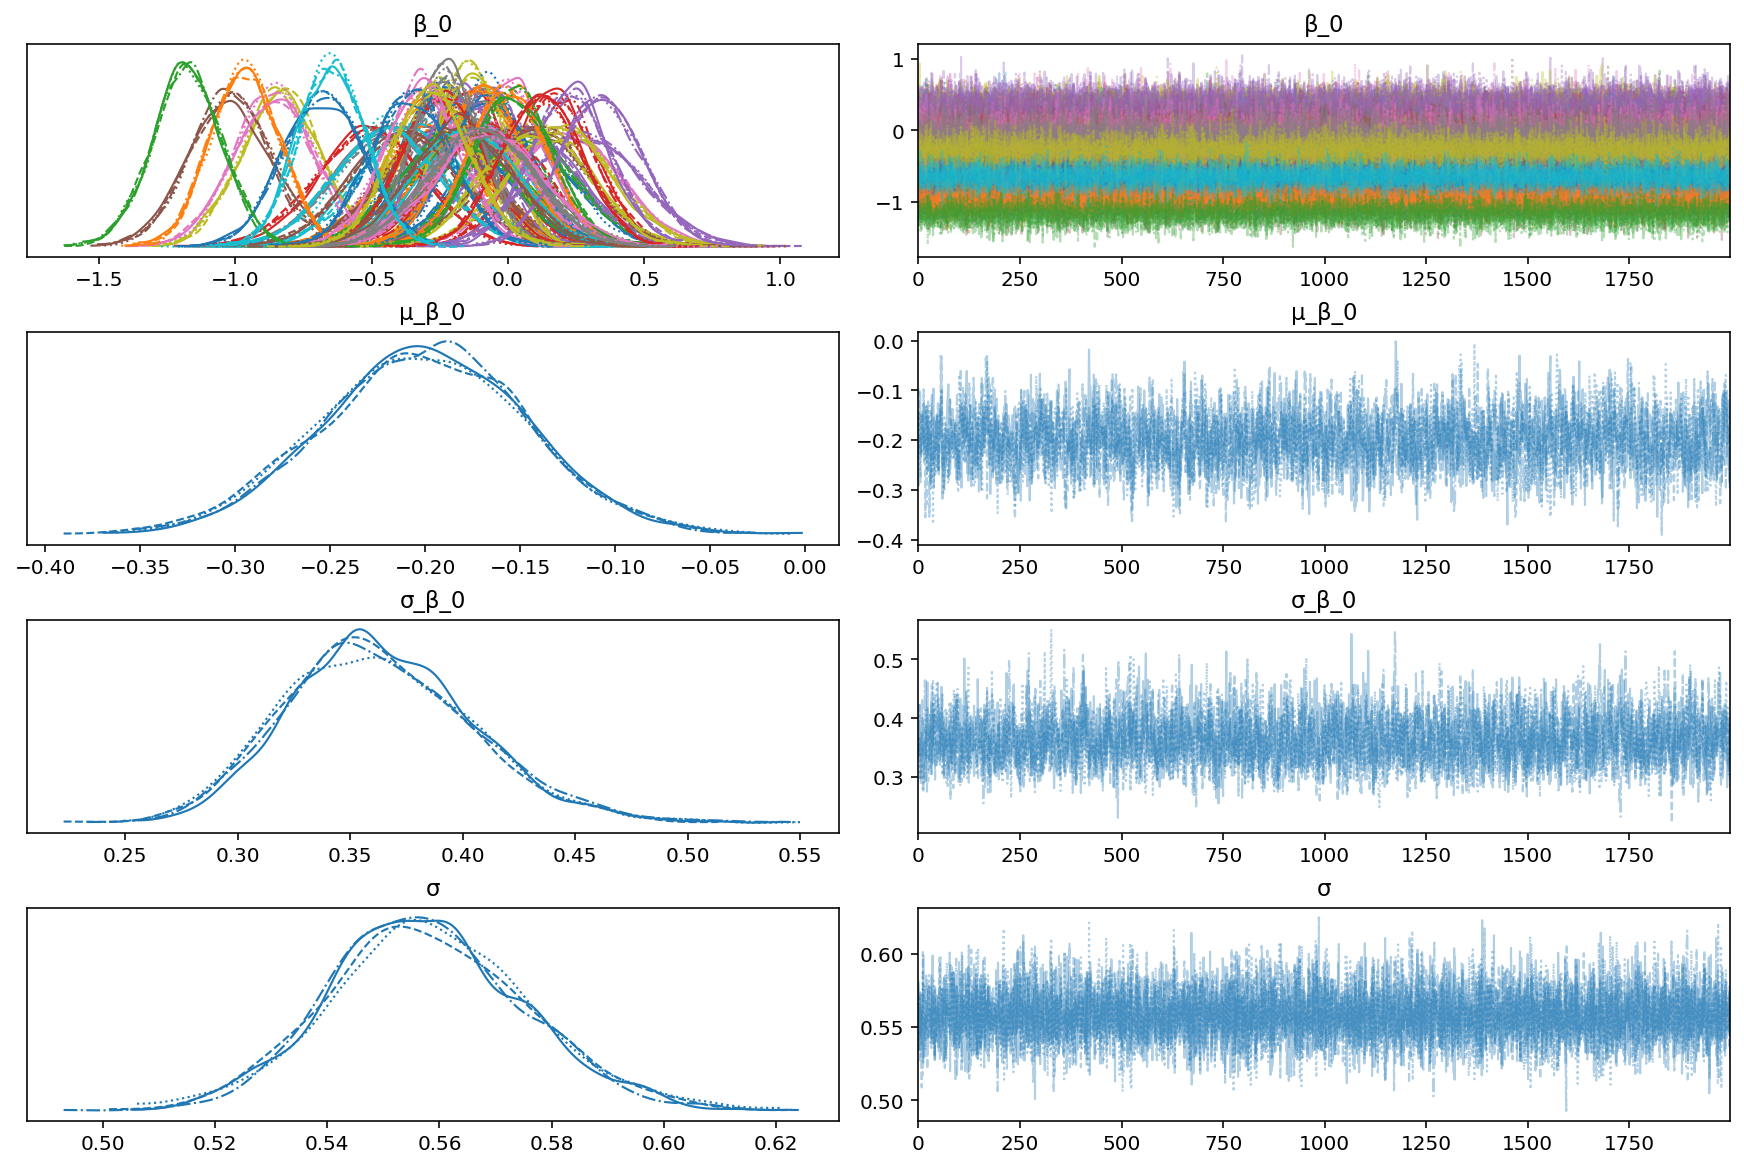

In [20]:
lin_varnames = shared_varnames.copy() + ["σ"]
az.plot_trace(lin_trace, var_names=lin_varnames);

In [21]:
def get_beta_0_summary(name: str, idata: az.InferenceData) -> pd.DataFrame:
    return (
        az.summary(idata, var_names="β_0", kind="stats", hdi_prob=0.89)
        .assign(hugo_symbol=data.hugo_symbol.cat.categories, model=name)
        .reset_index(drop=False)
        .rename(columns={"index": "parameter"})
    )


beta_0_post = pd.concat([get_beta_0_summary(n, d) for n, d in model_collection.items()])
beta_0_post.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol              model
0    β_0[0]  0.081  0.122    -0.122      0.267      ACVR1C  negative binomial
1    β_0[1] -0.086  0.096    -0.251      0.054     ADPRHL1  negative binomial
2    β_0[2]  0.094  0.124    -0.106      0.289         APC  negative binomial
3    β_0[3] -0.035  0.095    -0.185      0.117        BRAF  negative binomial
4    β_0[4] -0.003  0.092    -0.151      0.140        CCR3  negative binomial

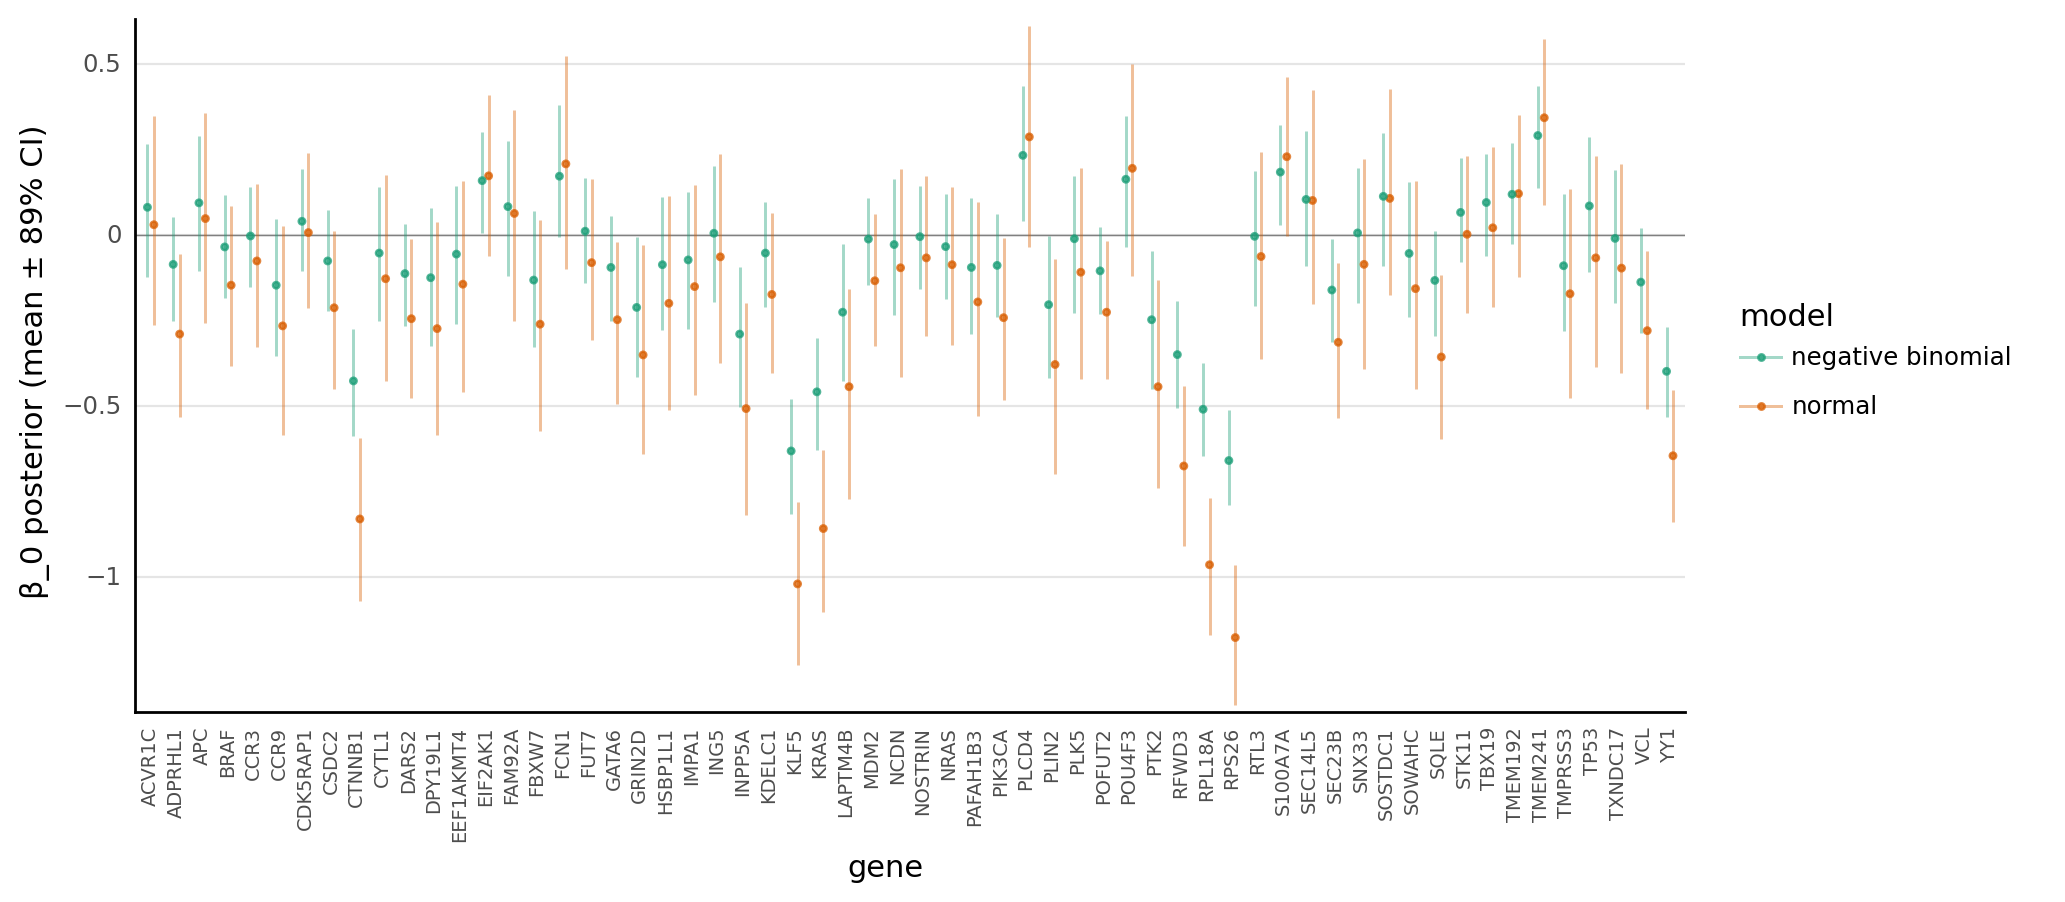

<ggplot: (349029961)>

In [22]:
pos = gg.position_dodge(width=0.5)

(
    gg.ggplot(beta_0_post, gg.aes(x="hugo_symbol", y="mean", color="model"))
    + gg.geom_hline(yintercept=0, linetype="-", size=0.3, color="grey")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), position=pos, size=0.6, alpha=0.4
    )
    + gg.geom_point(position=pos, size=0.8, alpha=0.75)
    + gg.scale_y_continuous(expand=(0.01, 0))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=7), figure_size=(10, 4.5))
    + gg.labs(x="gene", y="β_0 posterior (mean ± 89% CI)")
)

posterior distributions in negative binomial model


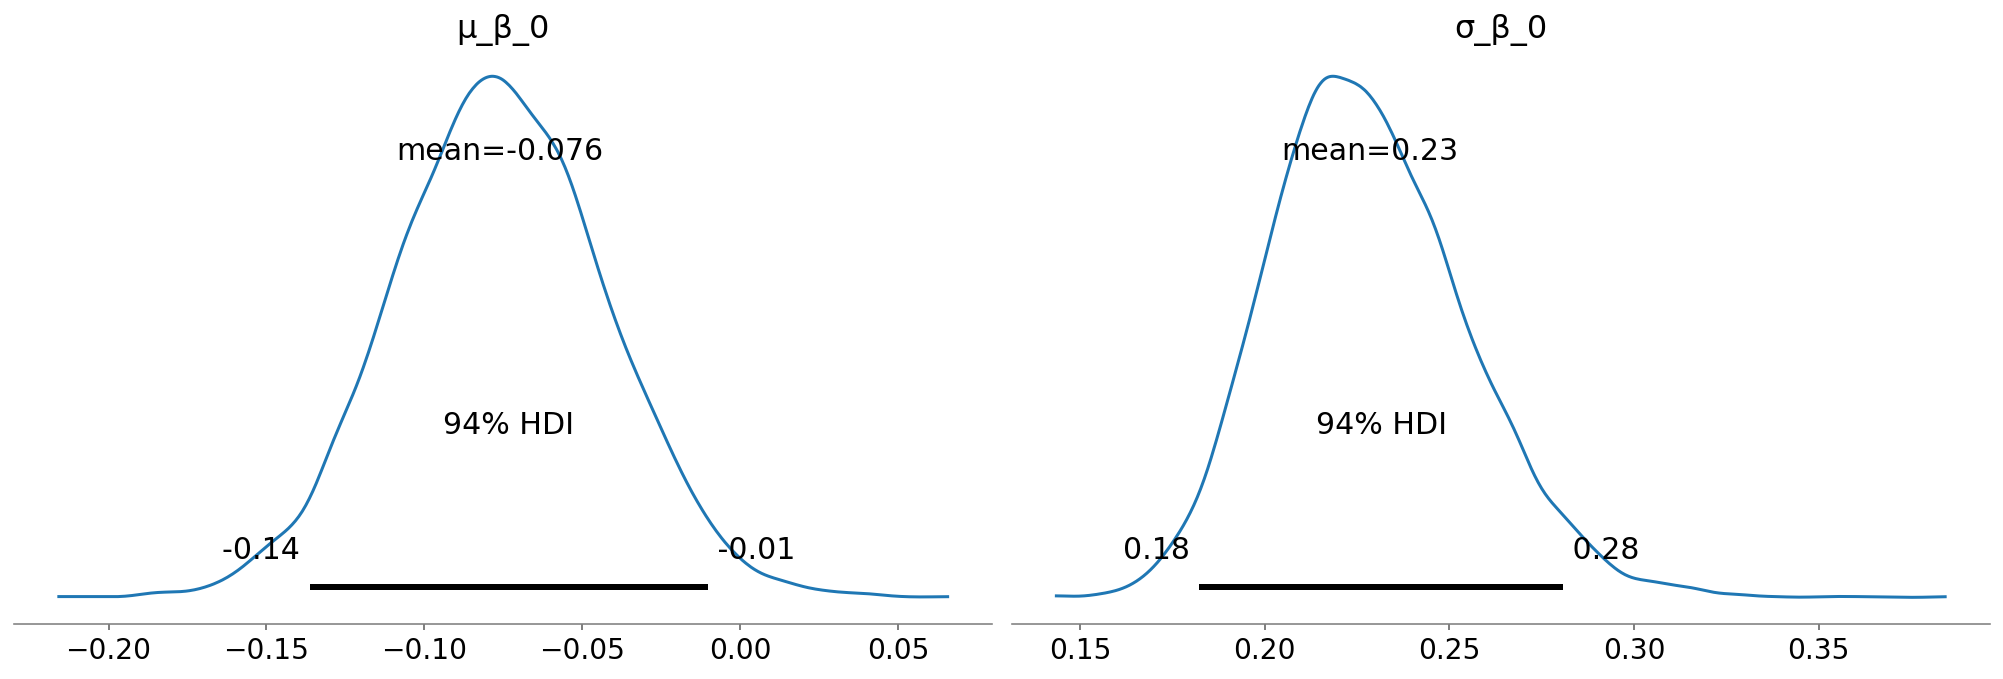

--------------------------------------------------------------------------------
posterior distributions in normal model


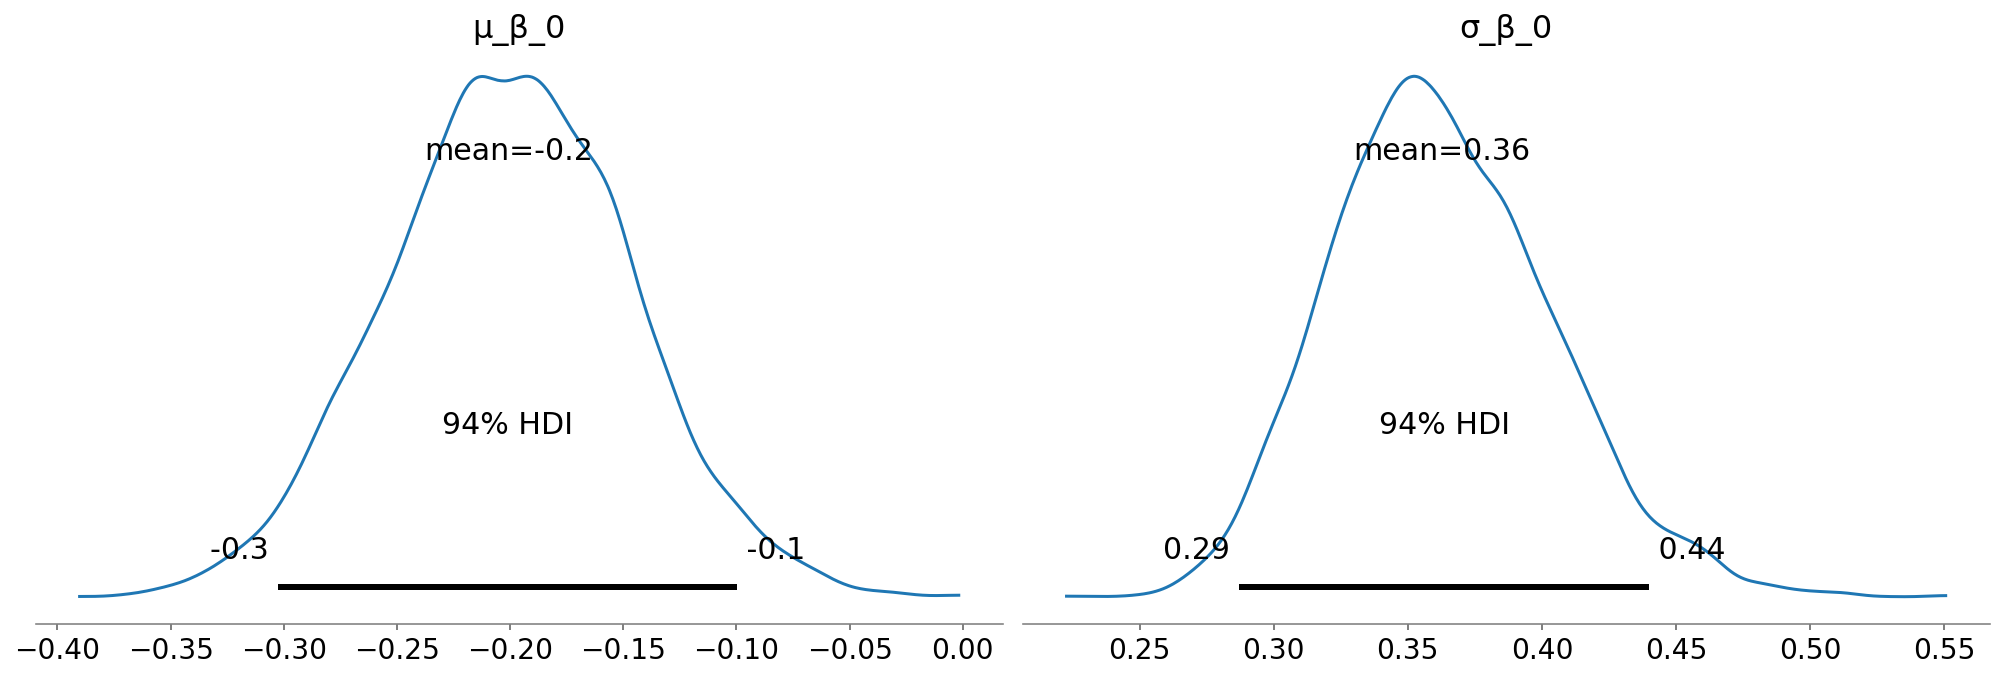

--------------------------------------------------------------------------------


In [23]:
for name, idata in model_collection.items():
    print(f"posterior distributions in {name} model")
    az.plot_posterior(idata, var_names=["μ_β_0", "σ_β_0"])
    plt.show()
    print("-" * 80)

### Posterior predictive checks

In [24]:
def prep_ppc(name: str, idata: az.InferenceData, observed_y: str) -> pd.DataFrame:
    df = pmanal.summarize_posterior_predictions(
        idata["posterior_predictive"]["y"].values.squeeze(),
        merge_with=data[["hugo_symbol", "lfc", "counts_final", "counts_initial"]],
        calc_error=True,
        observed_y=observed_y,
    ).assign(
        model=name,
        percent_error=lambda d: 100 * (d[observed_y] - d.pred_mean) / d[observed_y],
        real_value=lambda d: d[observed_y],
    )

    if observed_y == "counts_final":
        df["pred_lfc"] = np.log2(df.pred_mean / df.counts_initial)
        df["pred_lfc_low"] = np.log2(df.pred_hdi_low / df.counts_initial)
        df["pred_lfc_high"] = np.log2(df.pred_hdi_high / df.counts_initial)
    else:
        df["pred_lfc"] = df.pred_mean
        df["pred_lfc_low"] = df.pred_hdi_low
        df["pred_lfc_high"] = df.pred_hdi_high

    df["lfc_error"] = df["lfc"] - df["pred_lfc"]

    return df


ppc_df = pd.concat(
    [
        prep_ppc(m[0], m[1], y)
        for m, y in zip(model_collection.items(), ("counts_final", "lfc"))
    ]
)
ppc_df.head()

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


pred_mean  pred_hdi_low  pred_hdi_high hugo_symbol       lfc  \
0  290.960875         119.0          455.0      ACVR1C  0.296921   
1  418.738125         168.0          650.0      ACVR1C  0.944830   
2  589.842500         257.0          934.0      ACVR1C -0.646824   
3  315.152500         125.0          490.0      ACVR1C -0.016798   
4  379.070750         149.0          587.0      ACVR1C -0.074812   

   counts_final  counts_initial       error              model  percent_error  \
0         329.0      267.802016   38.039125  negative binomial      11.562044   
1         741.0      384.942637  322.261875  negative binomial      43.490132   
2         344.0      538.606821 -245.842500  negative binomial     -71.465843   
3         286.0      289.349513  -29.152500  negative binomial     -10.193182   
4         329.0      346.510616  -50.070750  negative binomial     -15.219073   

   real_value  pred_lfc  pred_lfc_low  pred_lfc_high  lfc_error  
0       329.0  0.119658     -1.170205       0.764700   0.177262  
1       741.0  0.121405     -1.196182       0.755796   0.823425  
2       344.0  0.131097     -1.067464       0.794190  -0.777921  
3       286.0  0.123237     -1.210885       0.759969  -0.140035  
4       329.0  0.129568     -1.217587       0.760461  -0.204380

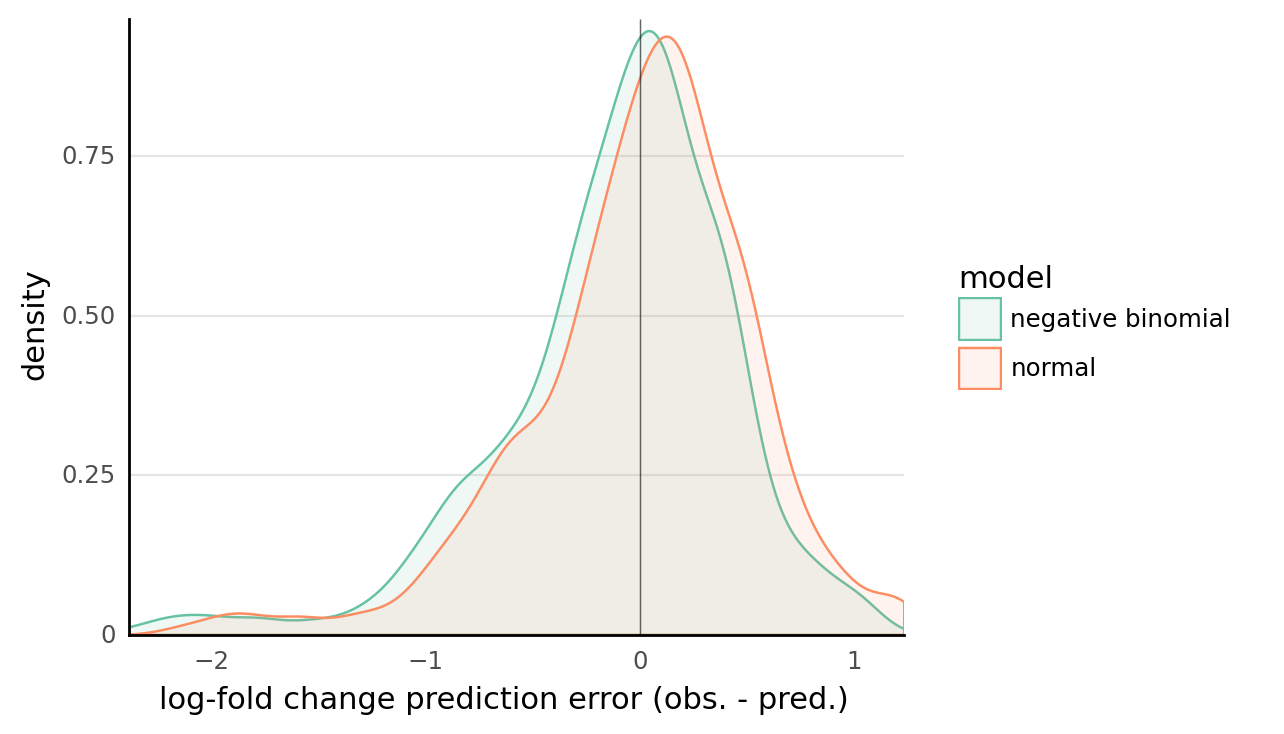

<ggplot: (347772245)>

In [25]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc_error"))
    + gg.geom_density(gg.aes(color="model", fill="model"), alpha=0.1)
    + gg.geom_vline(gg.aes(xintercept=0), alpha=0.6, size=0.3)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Set2")
    + gg.scale_fill_brewer(type="qual", palette="Set2")
    + gg.theme(figure_size=(5, 4))
    + gg.labs(x="log-fold change prediction error (obs. - pred.)")
)

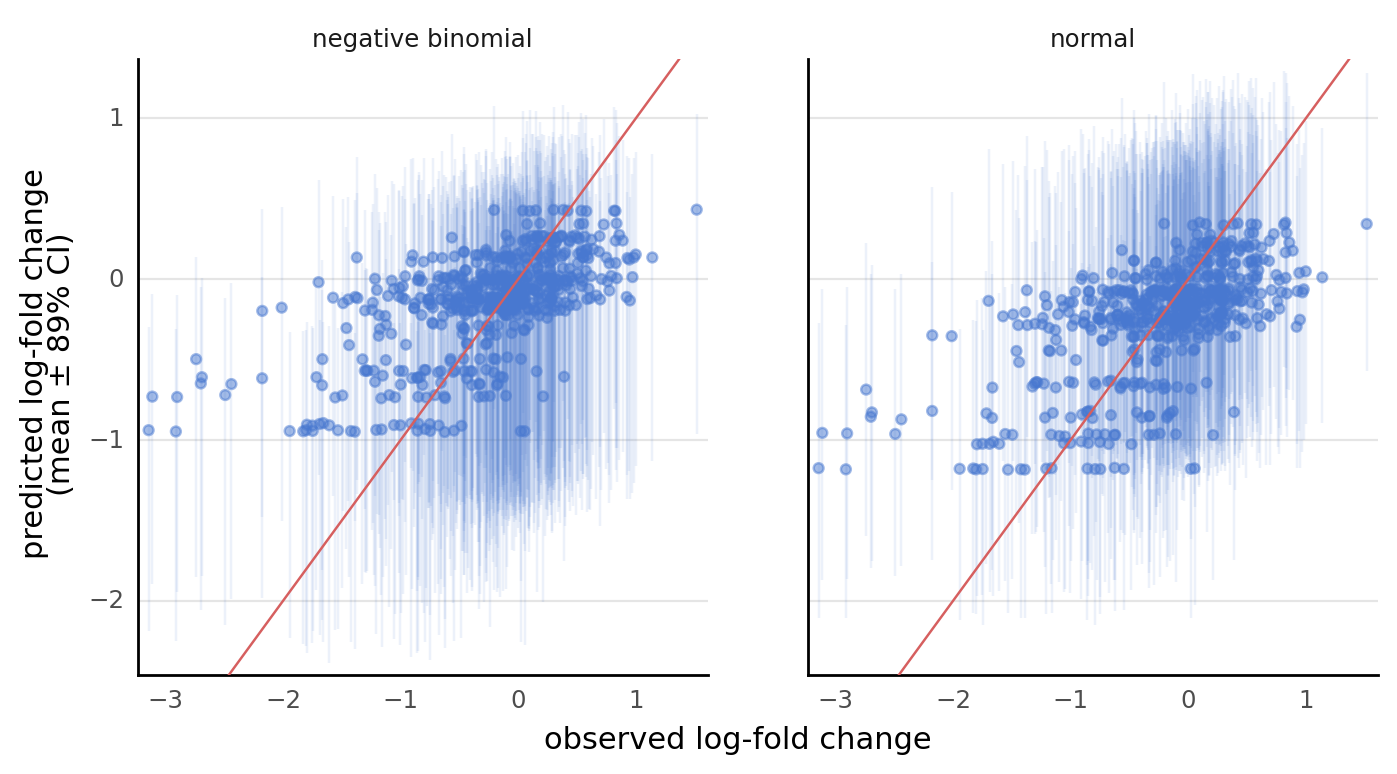

<ggplot: (348630851)>

In [26]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc", y="pred_lfc"))
    + gg.facet_wrap("~ model", nrow=1)
    + gg.geom_linerange(
        gg.aes(ymin="pred_lfc_low", ymax="pred_lfc_high"),
        alpha=0.1,
        size=0.5,
        color=SeabornColor.BLUE,
    )
    + gg.geom_point(alpha=0.5, color=SeabornColor.BLUE)
    + gg.geom_abline(slope=1, intercept=0, color=SeabornColor.RED)
    + gg.scale_x_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0.02, 0, 0.02, 0))
    + gg.theme(figure_size=(8, 4), panel_spacing_x=0.5)
    + gg.labs(
        x="observed log-fold change", y="predicted log-fold change\n(mean ± 89% CI)"
    )
)

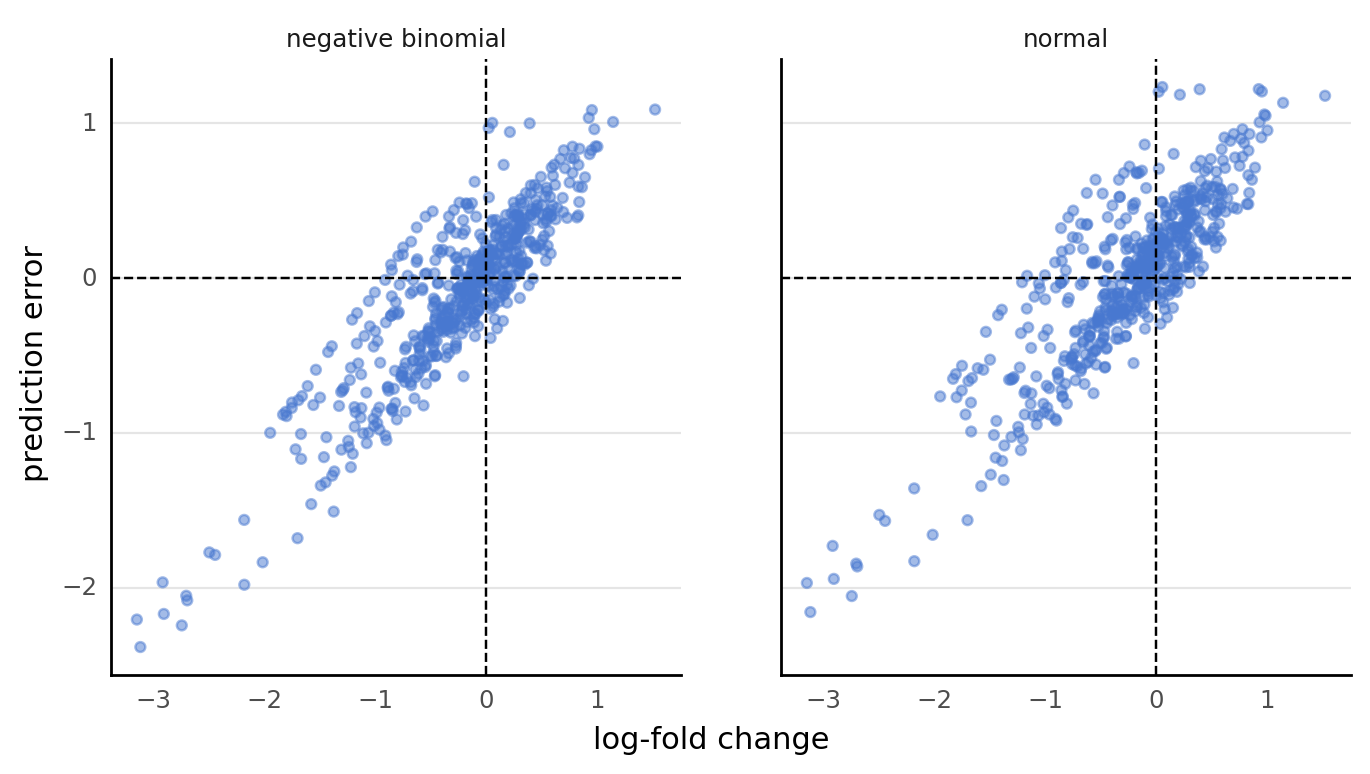

<ggplot: (347901883)>

In [27]:
(
    gg.ggplot(ppc_df, gg.aes(x="lfc", y="lfc_error"))
    + gg.facet_wrap("~ model", nrow=1)
    + gg.geom_point(alpha=0.5, color=SeabornColor.BLUE)
    + gg.geom_hline(yintercept=0, linetype="--")
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.theme(figure_size=(8, 4), panel_spacing_x=0.5)
    + gg.labs(x="log-fold change", y="prediction error")
)

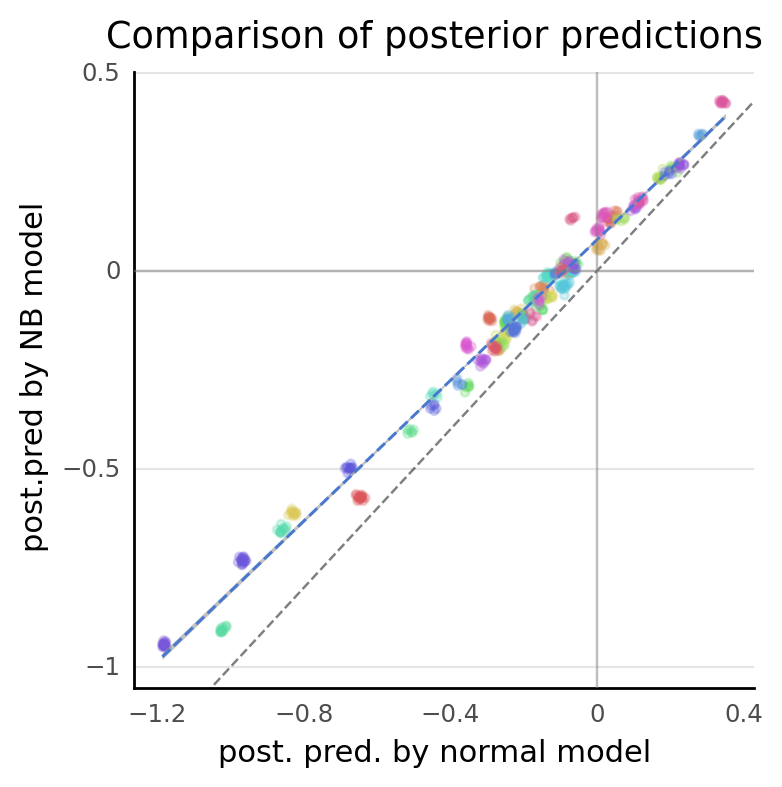

<ggplot: (346575129)>

In [28]:
(
    gg.ggplot(
        ppc_df[["model", "pred_lfc", "hugo_symbol"]]
        .pivot_wider(names_from="model", values_from="pred_lfc")
        .merge(data, left_index=True, right_index=True),
        gg.aes(x="normal", y="negative binomial"),
    )
    + gg.geom_point(
        gg.aes(color="hugo_symbol"), size=1.2, alpha=0.25, show_legend=False
    )
    + gg.geom_abline(slope=1, intercept=0, linetype="--", alpha=0.5)
    + gg.geom_smooth(
        method="lm",
        formula="y~x",
        alpha=0.6,
        linetype="--",
        size=0.6,
        color=SeabornColor.BLUE,
    )
    + gg.geom_hline(yintercept=0, alpha=0.5, color="grey")
    + gg.geom_vline(xintercept=0, alpha=0.5, color="grey")
    + gg.scale_color_hue()
    + gg.labs(
        x="post. pred. by normal model",
        y="post.pred by NB model",
        title="Comparison of posterior predictions",
    )
)

---

In [29]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 9.98 minutes


In [30]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-09-20

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: nb-model

matplotlib: 3.4.3
seaborn   : 0.11.2
plotnine  : 0.8.0
re        : 2.2.1
logging   : 0.5.1.2
pandas    : 1.3.2
numpy     : 1.21.2
theano    : 1.0.5
arviz     : 0.11.2
pymc3     : 3.11.2

